<a href="https://colab.research.google.com/github/eyalmakdushi/Natural-Language-Processing-Project/blob/main/finalProjectEyalMakdushi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Eyal Makdushi 208879718

I am working on developing an intelligent system that can provide relevant answers or information from written text. My approach involves two different methods. The first method is by fine-tuning ChatGPT using a dataset called the AG News Classification Dataset, which is categorized into four key topics: 1-World, 2-Sports, 3-Business, and 4-Sci/Tech. I believe this method will deliver better accuracy.

The second approach involves training a sequence-to-sequence (seq2seq) LSTM model on the same dataset, aiming to accurately respond to questions within these topics. Ultimately, I aim to leverage OpenAI’s API models for delivering accurate answers, with the goal of determining which method provides the best performance.

## Step 1: Data Preprocessing

In [ ]:
# Step 1: Data Preprocessing
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from google.colab import files

# Download nltk dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("uploading test.csv file")
uploaded_test = files.upload()
print("uploading train.csv file")
uploaded_train = files.upload()

test_df = pd.read_csv("test.csv", nrows=500)
train_df = pd.read_csv("train.csv", nrows=1000)

# DataProcessor Class for Preprocessing
class DataProcessor:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def preprocess(self, column, stop_words):
        self.dataframe[column] = self.dataframe[column].str.lower()
        self.dataframe[column] = self.dataframe[column].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
        self.dataframe[column] = self.dataframe[column].apply(word_tokenize)
        self.dataframe[column] = self.dataframe[column].apply(lambda x: [word for word in x if word not in stop_words])
        lemmatizer = WordNetLemmatizer()
        self.dataframe[column] = self.dataframe[column].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    def get_processed_dataframe(self):
        return self.dataframe

# Preprocessing train and test data
stop_words = set(stopwords.words('english'))

processor_train = DataProcessor(train_df)
processor_train.preprocess('Title', stop_words)
processor_train.preprocess('Description', stop_words)

processor_test = DataProcessor(test_df)
processor_test.preprocess('Title', stop_words)
processor_test.preprocess('Description', stop_words)


uploading test.csv file


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving test.csv to test (2).csv
uploading train.csv file


Saving train.csv to train (2).csv


## Step 2: Build Vocabulary

In [ ]:
# Step 2: Build Vocabulary
def build_vocab(data):
    vocab = set()
    for _, row in data.iterrows():
        vocab.update(row['Title'])
        vocab.update(row['Description'])
    return vocab

vocab = build_vocab(train_df)
word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}
word_to_index['<UNK>'] = len(word_to_index)

# Convert Text to Indices
def text_to_indices(tokens):
    return [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]

train_df['Title'] = train_df['Title'].apply(text_to_indices)
train_df['Description'] = train_df['Description'].apply(text_to_indices)
test_df['Title'] = test_df['Title'].apply(text_to_indices)
test_df['Description'] = test_df['Description'].apply(text_to_indices)

# Dataset and DataLoader for LSTM
class QADataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.max_seq_length = max(max(len(row['Title']), len(row['Description'])) for _, row in dataframe.iterrows())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq = torch.tensor(self.data.iloc[idx]['Title'], dtype=torch.long)
        target_seq = torch.tensor(self.data.iloc[idx]['Description'], dtype=torch.long)
        input_seq = nn.functional.pad(input_seq, (0, self.max_seq_length - len(input_seq)), value=0)
        target_seq = nn.functional.pad(target_seq, (0, self.max_seq_length - len(target_seq)), value=0)
        return input_seq, target_seq

# Create DataLoaders
batch_size = 32
train_dataset = QADataset(train_df)
test_dataset = QADataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Step 3: Seq2Seq LSTM Model Definition and Training

In [ ]:
# Step 3: Seq2Seq LSTM Model Definition and Training
class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(Seq2SeqLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Embedding layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)  # LSTM with batch_first=True
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer to map to output vocab

    def forward(self, x):
        x = self.embedding(x)  # Convert input indices to embeddings
        lstm_out, _ = self.lstm(x)  # LSTM returns all hidden states for each time step
        # lstm_out shape: (batch_size, sequence_length, hidden_dim)

        # Apply the fully connected layer to each time step
        output = self.fc(lstm_out)  # Output shape: (batch_size, sequence_length, vocab_size)
        return output  # Return the output for all time steps


def train_lstm_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Move inputs and targets to the device (e.g., GPU)
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass through the model (LSTM)
            outputs = model(inputs)  # Output shape: (batch_size, sequence_length, vocab_size)

            # Reshape outputs to (batch_size * sequence_length, vocab_size)
            outputs = outputs.view(-1, outputs.size(-1))  # Shape: (batch_size * sequence_length, vocab_size)

            # Reshape targets to be (batch_size * sequence_length)
            targets = targets.view(-1)  # Shape: (batch_size * sequence_length)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Track the running loss
            running_loss += loss.item()

        # Output the average loss for the epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

vocab_size = len(word_to_index)  # The size of your vocabulary
embed_dim = 128  # Embedding size (this can be adjusted)
hidden_dim = 128  # Hidden state size for LSTM
output_dim = vocab_size  # Output dimension should match vocab size for Seq2Seq tasks

# Initialize the Seq2SeqLSTM model with the correct arguments
lstm_model = Seq2SeqLSTM(vocab_size, embed_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the appropriate device
lstm_model.to(device)

# Train the model
train_lstm_model(lstm_model, train_loader, criterion, optimizer, device, epochs=10)

# Evaluation Function for LSTM
def calculate_sequence_accuracy(predictions, targets):
    # Flatten both predictions and targets
    predicted = torch.argmax(predictions, dim=2)  # Shape: (batch_size, sequence_length)

    # Compare predictions with targets for each element in the sequence
    correct = (predicted == targets).float()  # Returns a tensor of shape (batch_size, sequence_length) with 1s and 0s
    accuracy = correct.sum() / correct.numel()  # Total correct / total number of elements
    return accuracy.item()  # Return accuracy as a scalar

def evaluate_model(model, test_loader, device):
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Output shape: (batch_size, sequence_length, vocab_size)

            # Calculate sequence-level accuracy
            accuracy = calculate_sequence_accuracy(outputs, targets)
            total_accuracy += accuracy
    return total_accuracy / len(test_loader)  # Average accuracy over all batches


# Evaluate LSTM Model
test_accuracy = evaluate_model(lstm_model, test_loader, device)
print(f"Seq2Seq LSTM Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10, Loss: 5.202561065554619
Epoch 2/10, Loss: 2.9627756103873253
Epoch 3/10, Loss: 2.8924663960933685
Epoch 4/10, Loss: 2.778308719396591
Epoch 5/10, Loss: 2.7227553352713585
Epoch 6/10, Loss: 2.6458578407764435
Epoch 7/10, Loss: 2.6342481300234795
Epoch 8/10, Loss: 2.5593893192708492
Epoch 9/10, Loss: 2.543581038713455
Epoch 10/10, Loss: 2.5096936747431755
Seq2Seq LSTM Test Accuracy: 0.6759


## Step 4: Fine-tuning GPT-2 for Q&A

In [ ]:
# Step 4: Fine-tuning GPT-2 for Q&A
# Prepare GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

# Add special tokens
special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
tokenizer.add_special_tokens(special_tokens_dict)
model_gpt2.resize_token_embeddings(len(tokenizer))

train_df['context'] = train_df['Title'].astype(str) + ' ' + train_df['Description'].astype(str)
test_df['context'] = test_df['Title'].astype(str) + ' ' + test_df['Description'].astype(str)

class QADatasetGPT2(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context = self.data.iloc[idx]['context']
        inputs = self.tokenizer.encode(context, max_length=self.max_length, padding="max_length", truncation=True)
        input_ids = torch.tensor(inputs, dtype=torch.long)
        return {'input_ids': input_ids, 'labels': input_ids.clone()}

# Prepare GPT-2 datasets and dataloaders
train_dataset_gpt2 = QADatasetGPT2(train_df, tokenizer)
test_dataset_gpt2 = QADatasetGPT2(test_df, tokenizer)
train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=4, shuffle=True)
test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=4, shuffle=False)

def calculate_gpt2_accuracy(predictions, targets):
    predicted = torch.argmax(predictions, dim=-1)  # Get predicted token indices
    correct = (predicted == targets).float()  # Compare with target tokens
    accuracy = correct.sum() / correct.numel()  # Calculate overall accuracy
    return accuracy.item()

# Fine-tuning GPT-2
def fine_tune_gpt2_model(model, train_loader, optimizer, scheduler, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

optimizer_gpt2 = AdamW(model_gpt2.parameters(), lr=5e-5)
scheduler_gpt2 = get_linear_schedule_with_warmup(optimizer_gpt2, num_warmup_steps=0, num_training_steps=len(train_loader_gpt2)*3)

model_gpt2.to(device)
fine_tune_gpt2_model(model_gpt2, train_loader_gpt2, optimizer_gpt2, scheduler_gpt2, device, epochs=3)

# Evaluation Function for GPT-2
def evaluate_gpt2_model(model, test_loader, device):
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, labels=labels)

            # Use the new GPT-2 accuracy function
            accuracy = calculate_gpt2_accuracy(outputs.logits, labels)
            total_accuracy += accuracy

    return total_accuracy / len(test_loader)  # Average accuracy over all batches

# Evaluate GPT-2 Model
gpt2_accuracy = evaluate_gpt2_model(model_gpt2, test_loader_gpt2, device)
print(f"GPT-2 Test Accuracy: {gpt2_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 250/250 [02:22<00:00,  1.76it/s]


Epoch 1, Loss: 0.6756


Epoch 2/3: 100%|██████████| 250/250 [02:21<00:00,  1.77it/s]


Epoch 2, Loss: 0.4751


Epoch 3/3: 100%|██████████| 250/250 [02:21<00:00,  1.77it/s]


Epoch 3, Loss: 0.4662
GPT-2 Test Accuracy: 0.8434


## Step 5: Comparison of Results

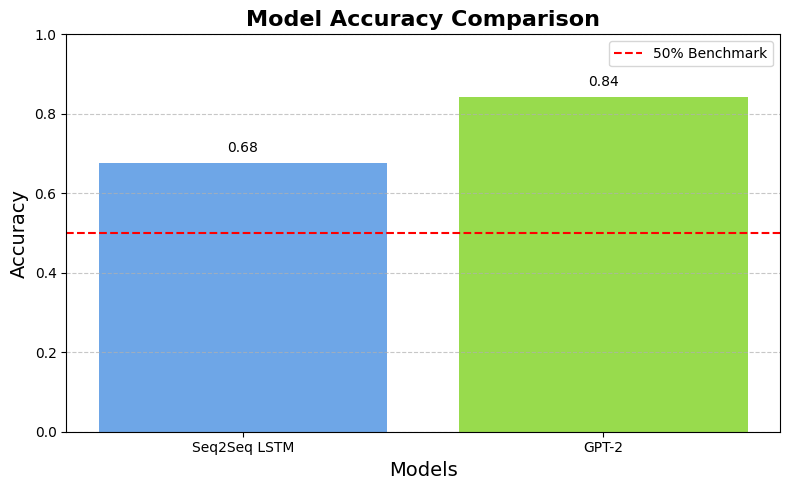

In [ ]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = ['Seq2Seq LSTM', 'GPT-2']
accuracies = [test_accuracy, gpt2_accuracy]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Bar plot
bars = ax.bar(models, accuracies, color=['#4A90E2', '#7ED321'], alpha=0.8)

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

# Customize plot
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle='--', label='50% Benchmark')  # Optional benchmark line
ax.legend()

# Show grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

